In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import wandb
wandb.login()

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: sahaana (use `wandb login --relogin` to force relogin)


True

# Imports 

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DistilBertModel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
import sys
sys.path.append('/lfs/1/sahaana/enrichment/enrich/utils')
    
from model_utils import MatchedDatasetTriplets, param_header_bert, tokenize_batch   
from models import BatchedTripletSingleTowerModel, BatchedTripletSingleBERTModel
from model_runner import train_model, eval_model
from knn_utils import FaissKNeighbors, knn_matching_accuracy, find_perfect_recall

In [6]:
%load_ext autoreload
%autoreload 2

# Load Processed (cleaned, aligned) Datasets

In [7]:
saved_imdb = '/lfs/1/sahaana/enrichment/data/imdb/final_table_nogenre.pkl'
saved_summaries = '/lfs/1/sahaana/enrichment/data/wikidata/wikidata-processor/data/queries/movies/final_table_nogenre.pkl'

imdb = pd.read_pickle(saved_imdb)
summaries = pd.read_pickle(saved_summaries)
imdb_cols = 10
summaries_cols = 3

In [8]:
summaries

,QID,title,wikisummary,merged,merged_nogenre
0,Q93488200,Love Finds You in Valentine,Love Finds You in Valentine is a 2016 American...,wikisummary Love Finds You in Valentine is a 2...,wikisummary Love Finds You in Valentine is a 2...
1,Q3242,A Fantastic Fear of Everything,A Fantastic Fear of Everything is a 2012 Briti...,wikisummary A Fantastic Fear of Everything is ...,wikisummary A Fantastic Fear of Everything is ...
2,Q4316,Project A-ko,"Project A-ko (A, Purojekuto ko) is a 1986 Japa...","wikisummary Project A-ko (A, Purojekuto ko) is...","wikisummary Project A-ko (A, Purojekuto ko) is..."
3,Q4471,Delirious (2006 film),Delirious is a 2006 comedy-drama film directed...,wikisummary Delirious is a 2006 comedy-drama f...,wikisummary Delirious is a 2006 comedy-drama f...
4,Q4815,Percy's Progress,Percy's Progress is a 1974 British comedy film...,wikisummary Percy's Progress is a 1974 British...,wikisummary Percy's Progress is a 1974 British...
...,...,...,...,...,...
47818,Q14723541,Hide and Seek (2013 film),Hide and Seek (Korean: ; RR: Sumbakkokjil) is ...,wikisummary Hide and Seek (Korean: ; RR: Sumba...,wikisummary Hide and Seek (Korean: ; RR: Sumba...
47819,Q14755291,Hush! Girls Don't Scream,"Hush! Girls Don't Scream (Persian: ! , roman...",wikisummary Hush! Girls Don't Scream (Persian:...,wikisummary Hush! Girls Don't Scream (Persian:...
47820,Q14774288,Garden of the Moon (film),Garden of the Moon is a 1938 American comedy f...,wikisummary Garden of the Moon is a 1938 Ameri...,wikisummary Garden of the Moon is a 1938 Ameri...
47821,Q14788814,Palo Alto (2013 film),Palo Alto is a 2013 American drama film writte...,wikisummary Palo Alto is a 2013 American drama...,wikisummary Palo Alto is a 2013 American drama...


In [9]:
imdb

,IMDB_ID,title_key,tconst,isAdult,titleType,primaryTitle,originalTitle,runtimeMinutes,genres,startYear,merged,merged_nogenre
0,tt4769430,4769430.0,tt4769430,0,tvMovie,Love Finds You in Valentine,Love Finds You in Valentine,87,"Drama,Romance",2016,"startYear 2016 [SEP] genres Drama,Romance [SEP...",startYear 2016 [SEP] runtimeMinutes 87 [SEP] o...
1,tt2006040,2006040.0,tt2006040,0,movie,A Fantastic Fear of Everything,A Fantastic Fear of Everything,100,"Comedy,Horror",2012,"startYear 2012 [SEP] genres Comedy,Horror [SEP...",startYear 2012 [SEP] runtimeMinutes 100 [SEP] ...
2,tt0091794,91794.0,tt0091794,0,movie,Project A-Ko,Purojekuto A-ko,86,"Action,Adventure,Animation",1986,"startYear 1986 [SEP] genres Action,Adventure,A...",startYear 1986 [SEP] runtimeMinutes 86 [SEP] o...
3,tt0412637,412637.0,tt0412637,0,movie,Delirious,Delirious,107,"Comedy,Drama,Romance",2006,"startYear 2006 [SEP] genres Comedy,Drama,Roman...",startYear 2006 [SEP] runtimeMinutes 107 [SEP] ...
4,tt0071677,71677.0,tt0071677,0,movie,It's Not the Size That Counts,Percy's Progress,90,Comedy,1974,startYear 1974 [SEP] genres Comedy [SEP] runti...,startYear 1974 [SEP] runtimeMinutes 90 [SEP] o...
...,...,...,...,...,...,...,...,...,...,...,...,...
47818,tt3155654,3155654.0,tt3155654,0,movie,Hide and Seek,Sum-bakk-og-jil,107,"Action,Horror,Mystery",2013,"startYear 2013 [SEP] genres Action,Horror,Myst...",startYear 2013 [SEP] runtimeMinutes 107 [SEP] ...
47819,tt2440036,2440036.0,tt2440036,0,movie,Hush! Girls Don't Scream,Hiss Dokhtarha Faryad Nemizanand,106,Drama,2013,startYear 2013 [SEP] genres Drama [SEP] runtim...,startYear 2013 [SEP] runtimeMinutes 106 [SEP] ...
47820,tt0030171,30171.0,tt0030171,0,movie,Garden of the Moon,Garden of the Moon,94,"Comedy,Musical,Romance",1938,"startYear 1938 [SEP] genres Comedy,Musical,Rom...",startYear 1938 [SEP] runtimeMinutes 94 [SEP] o...
47821,tt2479800,2479800.0,tt2479800,0,movie,Palo Alto,Palo Alto,100,Drama,2013,startYear 2013 [SEP] genres Drama [SEP] runtim...,startYear 2013 [SEP] runtimeMinutes 100 [SEP] ...


(array([1.610e+02, 1.746e+03, 3.490e+03, 4.289e+03, 4.662e+03, 4.362e+03,
        3.977e+03, 3.429e+03, 3.057e+03, 2.618e+03, 2.113e+03, 1.832e+03,
        1.552e+03, 1.349e+03, 1.130e+03, 9.650e+02, 8.340e+02, 7.460e+02,
        6.310e+02, 5.410e+02, 4.880e+02, 3.930e+02, 3.590e+02, 3.170e+02,
        3.010e+02, 2.690e+02, 2.180e+02, 1.990e+02, 1.530e+02, 1.500e+02,
        1.640e+02, 1.620e+02, 1.270e+02, 1.170e+02, 8.400e+01, 1.000e+02,
        7.800e+01, 8.300e+01, 6.800e+01, 4.700e+01, 5.300e+01, 5.600e+01,
        3.600e+01, 3.700e+01, 3.400e+01, 3.900e+01, 3.500e+01, 2.200e+01,
        9.000e+00, 1.600e+01, 1.400e+01, 1.000e+01, 1.500e+01, 1.300e+01,
        8.000e+00, 6.000e+00, 9.000e+00, 9.000e+00, 5.000e+00, 7.000e+00,
        4.000e+00, 6.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

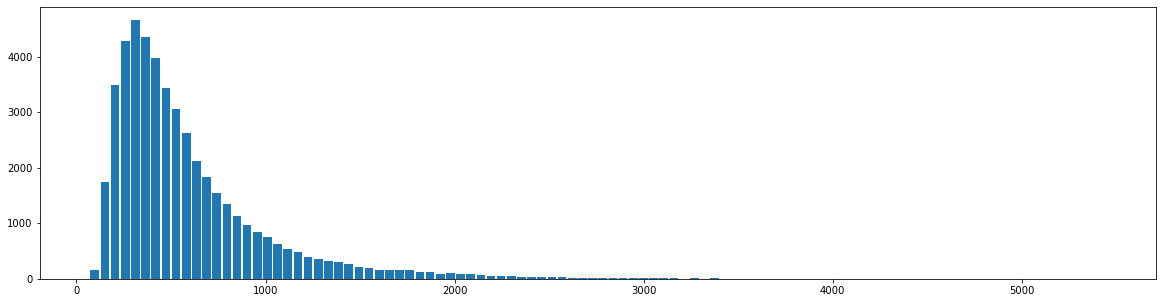

In [10]:
plt.figure(figsize=(20,5))
plt.hist(summaries['merged'].apply(lambda x: len(x)), bins=100, rwidth = .85)

# Prepping Data Indices

In [11]:
indices = np.arange(len(summaries))

In [12]:
n_train = 40000#500
n_test = 7823
train_idx = indices[:n_train]
test_idx = indices[-n_test:]

In [13]:
#num_train = 5000
#sampled_train_idx = np.random.choice(train_idx, num_train, replace = False)

train_imdb = imdb.iloc[train_idx]
test_imdb = imdb.iloc[test_idx]

train_summaries = summaries.iloc[train_idx]
test_summaries = summaries.iloc[test_idx]

## Model H Params

In [53]:
epochs = 1
batch_size = 8
final_size = 200
lr = .00001
tl_margin = 1.0
tl_p = 2
pool_type = "CLS"
column = "merged"
shuffle = True
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_max_length = 512
compute_val = False

bert_path='../../../tfidf_pre_training/BM25_MergedMaskedDBFT_nogenre_uncased'
bert_model = DistilBertModel.from_pretrained(bert_path, return_dict=True)

model_name = f'single-tower-BERT-FT-triplet-model-BM25'

## DataLoaders

In [54]:
train_data = DataLoader(MatchedDatasetTriplets(train_imdb.reset_index(), 
                                               train_summaries.reset_index(), 5), 
                        batch_size=batch_size,
                        shuffle = shuffle
                        )

val_data = DataLoader(MatchedDatasetTriplets(test_imdb.reset_index(), 
                                              test_summaries.reset_index(), 5), 
                       batch_size=batch_size,
                       shuffle = False
                      )

## Init and Run Model

In [55]:
triplet_loss = nn.TripletMarginLoss(margin=tl_margin, p=tl_p)
losses = []
val_losses = []
model = BatchedTripletSingleBERTModel(final_size, pool_type, bert_path)
optimizer = optim.AdamW(model.parameters(), lr=lr)#optim.SGD(model.parameters(), lr=lr)

In [56]:
save_dir = param_header_bert(batch_size, final_size, lr, tl_margin, tl_p, pool_type, shuffle)
save_dir = f'models/{model_name}/{save_dir}/'

In [57]:
wandb.init(project=model_name)

Epoch,0
_step,25000
_runtime,5430
_timestamp,1610539405
train batch loss,0.0


Epoch,▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train batch loss,▁▁▁▁▃▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: wandb version 0.10.13 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [58]:
train_model(model, tokenizer, tokenize_batch, train_data, val_data, triplet_loss, optimizer, epochs, losses, val_losses, save_dir, compute_val, tokenizer_max_length = tokenizer_max_length)

# k-NN Model Performance

In [20]:
#PATH = "models/single-tower-BERT-triplet-model/batch_size-8-final_size-50-opt_lr-0.0001-tloss_margin-1.0-tloss_p-2-pooling-CLS-shuffle-True00-35-05-01-21"
#model.load_state_dict(torch.load(PATH))

In [21]:
print(n_train, epochs, batch_size, final_size, lr)
all_data = DataLoader(MatchedDatasetTriplets(imdb.reset_index(), 
                                             summaries.reset_index(), 1), 
                      batch_size=batch_size
                     )
imdb_embeddings, summaries_embeddings = eval_model(model, tokenizer, tokenize_batch, all_data, tokenizer_max_length=512)

knn = FaissKNeighbors(k=30)
knn.fit(summaries_embeddings)
neib = knn.kneighbors(imdb_embeddings)

for k in range(30):
    print(k, *knn_matching_accuracy(neib[1], k, train_idx, test_idx))

40000 1 8 100 3e-05
0 0 0 0.0 0.0
1 36802 7125 0.92005 0.9107759171673271
2 37664 7268 0.9416 0.929055349610124
3 37980 7336 0.9495 0.93774766713537
4 38177 7384 0.954425 0.9438834206826026
5 38311 7417 0.957775 0.9481017512463249
6 38421 7439 0.960525 0.9509139716221399
7 38502 7460 0.96255 0.953598363799054
8 38571 7473 0.964275 0.9552601303847629
9 38639 7491 0.965975 0.957561037964975
10 38696 7499 0.9674 0.9585836635561805
11 38748 7508 0.9687 0.9597341173462866
12 38786 7513 0.96965 0.96037325834079
13 38829 7518 0.970725 0.9610123993352934
14 38869 7528 0.971725 0.9622906813243002
15 38903 7536 0.972575 0.9633133069155055
16 38922 7540 0.97305 0.9638246197111082
17 38941 7542 0.973525 0.9640802761089097
18 38968 7549 0.9742 0.9649750735012144
19 38995 7550 0.974875 0.965102901700115
20 39015 7553 0.975375 0.965486386296817
21 39028 7553 0.9757 0.965486386296817
22 39041 7557 0.976025 0.9659976990924198
23 39056 7562 0.9764 0.9666368400869232
24 39077 7566 0.976925 0.967148152882

In [22]:
knn = FaissKNeighbors(k=50)
knn.fit(summaries_embeddings)
neib = knn.kneighbors(imdb_embeddings)

for k in range(30,50):
    print(k, *knn_matching_accuracy(neib[1], k, train_idx, test_idx))

30 39179 7589 0.979475 0.9700882014572415
31 39184 7591 0.9796 0.9703438578550428
32 39197 7595 0.979925 0.9708551706506455
33 39208 7599 0.9802 0.9713664834462482
34 39221 7601 0.980525 0.9716221398440495
35 39225 7603 0.980625 0.971877796241851
36 39235 7608 0.980875 0.9725169372363544
37 39253 7610 0.981325 0.9727725936341557
38 39264 7614 0.9816 0.9732839064297584
39 39271 7615 0.981775 0.973411734628659
40 39279 7616 0.981975 0.9735395628275597
41 39287 7616 0.982175 0.9735395628275597
42 39290 7621 0.98225 0.9741787038220632
43 39303 7622 0.982575 0.9743065320209638
44 39308 7625 0.9827 0.9746900166176659
45 39315 7625 0.982875 0.9746900166176659
46 39318 7627 0.98295 0.9749456730154672
47 39322 7629 0.98305 0.9752013294132685
48 39326 7630 0.98315 0.9753291576121692
49 39332 7632 0.9833 0.9755848140099705


In [22]:
print(n_train, epochs, batch_size, final_size, lr)
all_data = DataLoader(MatchedDatasetTriplets(imdb.reset_index(), 
                                             summaries.reset_index(), 1), 
                      batch_size=batch_size
                     )
imdb_embeddings, summaries_embeddings = eval_model(model, tokenizer, tokenize_batch, all_data, tokenizer_max_length=512)

knn = FaissKNeighbors(k=30)
knn.fit(summaries_embeddings)
neib = knn.kneighbors(imdb_embeddings)

for k in range(30):
    print(k, *knn_matching_accuracy(neib[1], k, train_idx, test_idx))

40000 1 8 25 3e-05
0 0 0 0.0 0.0
1 30873 5814 0.771825 0.7431931484085389
2 33289 6330 0.832225 0.8091524990412885
3 34258 6521 0.85645 0.833567685031318
4 34852 6646 0.8713 0.8495462098939026
5 35288 6731 0.8822 0.8604116068004601
6 35572 6793 0.8893 0.8683369551323021
7 35804 6850 0.8951 0.8756231624696408
8 36007 6891 0.900175 0.8808641186245686
9 36174 6923 0.90435 0.8849546209893903
10 36309 6950 0.907725 0.8884059823597086
11 36441 6971 0.911025 0.8910903745366228
12 36539 6997 0.913475 0.8944139077080404
13 36638 7015 0.91595 0.8967148152882526
14 36738 7040 0.91845 0.8999105202607696
15 36807 7059 0.920175 0.9023392560398824
16 36887 7070 0.922175 0.9037453662277899
17 36973 7091 0.924325 0.9064297584047041
18 37039 7106 0.925975 0.9083471813882142
19 37104 7122 0.9276 0.9103924325706251
20 37160 7132 0.929 0.9116707145596319
21 37217 7151 0.930425 0.9140994503387447
22 37265 7152 0.931625 0.9142272785376454
23 37303 7167 0.932575 0.9161447015211556
24 37340 7179 0.9335 0.91767

In [29]:
print(n_train, epochs, batch_size, final_size, lr)
all_data = DataLoader(MatchedDatasetTriplets(imdb.reset_index(), 
                                             summaries.reset_index(), 1), 
                      batch_size=batch_size
                     )
imdb_embeddings, summaries_embeddings = eval_model(model, tokenizer, tokenize_batch, all_data, tokenizer_max_length=512)

knn = FaissKNeighbors(k=30)
knn.fit(summaries_embeddings)
neib = knn.kneighbors(imdb_embeddings)

for k in range(30):
    print(k, *knn_matching_accuracy(neib[1], k, train_idx, test_idx))

40000 1 8 25 1e-05
0 0 0 0.0 0.0
1 35985 6855 0.899625 0.8762623034641442
2 37383 7188 0.934575 0.9188290936980698
3 37816 7308 0.9454 0.9341684775661511
4 38085 7352 0.952125 0.9397929183177809
5 38248 7379 0.9562 0.9432442796880992
6 38400 7406 0.96 0.9466956410584175
7 38477 7425 0.961925 0.9491243768375304
8 38565 7442 0.964125 0.9512974562188419
9 38652 7456 0.9663 0.9530870510034514
10 38719 7469 0.967975 0.9547488175891602
11 38784 7475 0.9696 0.9555157867825642
12 38823 7491 0.970575 0.957561037964975
13 38875 7502 0.971875 0.9589671481528825
14 38916 7509 0.9729 0.9598619455451872
15 38944 7517 0.9736 0.9608845711363927
16 38979 7524 0.974475 0.9617793685286974
17 39001 7528 0.975025 0.9622906813243002
18 39025 7535 0.975625 0.9631854787166049
19 39041 7539 0.976025 0.9636967915122076
20 39057 7546 0.976425 0.9645915889045124
21 39072 7552 0.9768 0.9653585580979164
22 39089 7558 0.977225 0.9661255272913205
23 39105 7562 0.977625 0.9666368400869232
24 39128 7571 0.9782 0.967787

In [36]:
print(n_train, epochs, batch_size, final_size, lr)
all_data = DataLoader(MatchedDatasetTriplets(imdb.reset_index(), 
                                             summaries.reset_index(), 1), 
                      batch_size=batch_size
                     )
imdb_embeddings, summaries_embeddings = eval_model(model, tokenizer, tokenize_batch, all_data, tokenizer_max_length=512)

knn = FaissKNeighbors(k=30)
knn.fit(summaries_embeddings)
neib = knn.kneighbors(imdb_embeddings)

for k in range(30):
    print(k, *knn_matching_accuracy(neib[1], k, train_idx, test_idx))

40000 1 8 75 1e-05
0 0 0 0.0 0.0
1 37883 7284 0.947075 0.9311006007925349
2 38782 7490 0.96955 0.9574332097660744
3 39023 7546 0.975575 0.9645915889045124
4 39159 7571 0.978975 0.9677872938770292
5 39262 7588 0.98155 0.9699603732583408
6 39328 7611 0.9832 0.9729004218330564
7 39384 7624 0.9846 0.9745621884187652
8 39422 7637 0.98555 0.976223955004474
9 39457 7646 0.986425 0.97737440879458
10 39474 7652 0.98685 0.9781413779879842
11 39499 7661 0.987475 0.9792918317780902
12 39521 7664 0.988025 0.9796753163747923
13 39539 7668 0.988475 0.980186629170395
14 39555 7674 0.988875 0.980953598363799
15 39570 7678 0.98925 0.9814649111594017
16 39586 7680 0.98965 0.9817205675572032
17 39599 7682 0.989975 0.9819762239550045
18 39613 7684 0.990325 0.9822318803528058
19 39622 7689 0.99055 0.9828710213473092
20 39634 7690 0.99085 0.9829988495462099
21 39643 7692 0.991075 0.9832545059440112
22 39649 7695 0.991225 0.9836379905407133
23 39657 7700 0.991425 0.9842771315352167
24 39660 7702 0.9915 0.9845

In [43]:
print(n_train, epochs, batch_size, final_size, lr)
all_data = DataLoader(MatchedDatasetTriplets(imdb.reset_index(), 
                                             summaries.reset_index(), 1), 
                      batch_size=batch_size
                     )
imdb_embeddings, summaries_embeddings = eval_model(model, tokenizer, tokenize_batch, all_data, tokenizer_max_length=512)

knn = FaissKNeighbors(k=30)
knn.fit(summaries_embeddings)
neib = knn.kneighbors(imdb_embeddings)

for k in range(30):
    print(k, *knn_matching_accuracy(neib[1], k, train_idx, test_idx))

40000 1 8 125 1e-05
0 0 0 0.0 0.0
1 38870 7512 0.97175 0.9602454301418893
2 39256 7611 0.9814 0.9729004218330564
3 39388 7640 0.9847 0.976607439601176
4 39466 7658 0.98665 0.9789083471813882
5 39521 7672 0.988025 0.9806979419659977
6 39567 7681 0.989175 0.9818483957561038
7 39598 7689 0.98995 0.9828710213473092
8 39624 7696 0.9906 0.983765818739614
9 39641 7700 0.991025 0.9842771315352167
10 39653 7710 0.991325 0.9855554135242235
11 39668 7714 0.9917 0.9860667263198262
12 39679 7715 0.991975 0.9861945545187268
13 39694 7719 0.99235 0.9867058673143295
14 39708 7722 0.9927 0.9870893519110315
15 39714 7724 0.99285 0.987345008308833
16 39717 7726 0.992925 0.9876006647066343
17 39725 7728 0.993125 0.9878563211044357
18 39732 7729 0.9933 0.9879841493033363
19 39742 7733 0.99355 0.988495462098939
20 39751 7736 0.993775 0.988878946695641
21 39754 7738 0.99385 0.9891346030934424
22 39759 7740 0.993975 0.9893902594912438
23 39762 7741 0.99405 0.9895180876901445
24 39766 7744 0.99415 0.9899015722

In [50]:
print(n_train, epochs, batch_size, final_size, lr)
all_data = DataLoader(MatchedDatasetTriplets(imdb.reset_index(), 
                                             summaries.reset_index(), 1), 
                      batch_size=batch_size
                     )
imdb_embeddings, summaries_embeddings = eval_model(model, tokenizer, tokenize_batch, all_data, tokenizer_max_length=512)

knn = FaissKNeighbors(k=30)
knn.fit(summaries_embeddings)
neib = knn.kneighbors(imdb_embeddings)

for k in range(30):
    print(k, *knn_matching_accuracy(neib[1], k, train_idx, test_idx))

40000 1 8 175 1e-05
0 0 0 0.0 0.0
1 38916 7552 0.9729 0.9653585580979164
2 39341 7652 0.983525 0.9781413779879842
3 39485 7677 0.987125 0.981337082960501
4 39556 7692 0.9889 0.9832545059440112
5 39604 7711 0.9901 0.9856832417231242
6 39638 7715 0.99095 0.9861945545187268
7 39662 7720 0.99155 0.9868336955132302
8 39683 7723 0.992075 0.9872171801099322
9 39702 7727 0.99255 0.987728492905535
10 39715 7729 0.992875 0.9879841493033363
11 39730 7736 0.99325 0.988878946695641
12 39737 7738 0.993425 0.9891346030934424
13 39749 7738 0.993725 0.9891346030934424
14 39759 7739 0.993975 0.989262431292343
15 39768 7740 0.9942 0.9893902594912438
16 39780 7742 0.9945 0.9896459158890452
17 39785 7743 0.994625 0.9897737440879458
18 39791 7747 0.994775 0.9902850568835485
19 39793 7751 0.994825 0.9907963696791512
20 39794 7753 0.99485 0.9910520260769525
21 39803 7755 0.995075 0.991307682474754
22 39808 7755 0.9952 0.991307682474754
23 39811 7757 0.995275 0.9915633388725553
24 39814 7758 0.99535 0.99169116

In [59]:
print(n_train, epochs, batch_size, final_size, lr)
all_data = DataLoader(MatchedDatasetTriplets(imdb.reset_index(), 
                                             summaries.reset_index(), 1), 
                      batch_size=batch_size
                     )
imdb_embeddings, summaries_embeddings = eval_model(model, tokenizer, tokenize_batch, all_data, tokenizer_max_length=512)

knn = FaissKNeighbors(k=30)
knn.fit(summaries_embeddings)
neib = knn.kneighbors(imdb_embeddings)

for k in range(30):
    print(k, *knn_matching_accuracy(neib[1], k, train_idx, test_idx))

40000 1 8 200 1e-05
0 0 0 0.0 0.0
1 38925 7558 0.973125 0.9661255272913205
2 39358 7658 0.98395 0.9789083471813882
3 39474 7687 0.98685 0.9826153649495079
4 39548 7700 0.9887 0.9842771315352167
5 39595 7712 0.989875 0.9858110699220248
6 39645 7717 0.991125 0.9864502109165282
7 39659 7723 0.991475 0.9872171801099322
8 39680 7732 0.992 0.9883676339000383
9 39703 7736 0.992575 0.988878946695641
10 39718 7740 0.99295 0.9893902594912438
11 39732 7743 0.9933 0.9897737440879458
12 39751 7745 0.993775 0.9900294004857472
13 39755 7747 0.993875 0.9902850568835485
14 39759 7748 0.993975 0.9904128850824492
15 39767 7750 0.994175 0.9906685414802505
16 39775 7750 0.994375 0.9906685414802505
17 39780 7750 0.9945 0.9906685414802505
18 39782 7751 0.99455 0.9907963696791512
19 39789 7751 0.994725 0.9907963696791512
20 39796 7751 0.9949 0.9907963696791512
21 39798 7752 0.99495 0.9909241978780519
22 39802 7752 0.99505 0.9909241978780519
23 39807 7752 0.995175 0.9909241978780519
24 39809 7752 0.995225 0.99